The code in this file was predominantly written by AI.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


In [3]:
# ── EVALUATION HELPER ─────────────────────────────
def evaluate_matchup(agent_path, opponent_path, n_games=200):
    """
    Play agent (from agent_path) vs opponent (from opponent_path).
    Returns (wins, losses, ties) from agent's perspective.
    If opponent_path is 'weak' or 'strong', uses BasicOpponent.
    """
    env = hockey_env.HockeyEnv()
    obs_dim = env.observation_space.shape[0]
    full_action_space = env.action_space
    n_per_player = full_action_space.shape[0] // 2
    action_space = spaces.Box(
        low=full_action_space.low[:n_per_player],
        high=full_action_space.high[:n_per_player],
        dtype=full_action_space.dtype
    )

    # load agent
    agent = TD3_Agent(
        obs_dim=obs_dim, act_dim=n_per_player,
        observation_space=env.observation_space,
        action_space=action_space, device='cpu'
    )
    agent.load(agent_path)

    # load opponent
    if opponent_path == 'weak':
        opponent = hockey_env.BasicOpponent(weak=True)
        opp_type = 'weak'
    elif opponent_path == 'strong':
        opponent = hockey_env.BasicOpponent(weak=False)
        opp_type = 'strong'
    else:
        opponent = TD3_Agent(
            obs_dim=obs_dim, act_dim=n_per_player,
            observation_space=env.observation_space,
            action_space=action_space, device='cpu'
        )
        opponent.load(opponent_path)
        opp_type = 'pretrained_self'

    wins, losses, ties = 0, 0, 0
    for _ in range(n_games):
        s1, _ = env.reset()
        s2 = env.obs_agent_two()
        ended = False
        while not ended:
            a1 = agent.select_action(s1, explore=False)
            if isinstance(opponent, hockey_env.BasicOpponent):
                a2 = opponent.act(s2)
            else:
                a2 = opponent.select_action(s2, explore=False)
            s1, _, terminated, truncated, info = env.step(np.hstack([a1, a2]))
            s2 = env.obs_agent_two()
            ended = terminated or truncated

        w = info.get('winner', 0)
        if w == 1:    wins += 1
        elif w == -1: losses += 1
        else:         ties += 1

    env.close()
    return wins, losses, ties

In [4]:
import pickle

with open('/Users/Anne/RL/Hockey-TD3/eval_results.pkl', 'rb') as f:
    data = pickle.load(f)

results = data['results']
paths_combined = data['paths_combined']

# ── RUN ALL MATCHUPS ──────────────────────────────
agent_names = list(paths_combined.keys())
N_GAMES = 200
# include weak and strong as "opponents" for the columns
all_opponents = ['weak', 'strong'] + agent_names

In [5]:
def add_new_results(additional_jobs, old_results, old_job_dict) -> dict:
    """
    additional_jobs dict {<name>: <path_to_agent>}
    old_job_dict dict {<oldname>: <path-to-old-agent>}
    """
    results_out = old_results
    for name1, path1 in additional_jobs.items():
        #assert old_results.get(name1) is None
        results_out[name1] = {}
        #path1 = paths_map_additional_jobs[name1]
        
        # vs weak
        print(f'{name1} vs weak ...', end=' ')
        w, l, t = evaluate_matchup(path1, 'weak', N_GAMES)
        results_out[name1]['weak'] = (w, l, t)
        print(f'W={w} L={l} T={t}')
        
        # vs strong
        print(f'{name1} vs strong ...', end=' ')
        w, l, t = evaluate_matchup(path1, 'strong', N_GAMES)
        results_out[name1]['strong'] = (w, l, t)
        print(f'W={w} L={l} T={t}')
        
        # vs other agents
        for name2, path2 in old_job_dict.items():
            print(f'{name1} vs {name2} ...', end=' ')
            w, l, t = evaluate_matchup(path1, path2, N_GAMES)
            results_out[name1][name2] = (w, l, t)
            results_out[name2][name1] = (l, w, t)
            print(f'W={w} L={l} T={t}')

        # all new against each other
        for name2, path2 in additional_jobs.items():
            if name1 == name2:
                results_out[name1][name2] = None
                continue
            if results_out.get(name2, {}).get(name1) is not None:
                # already computed from the other direction
                w_rev, l_rev, t_rev = results_out[name2][name1]
                results_out[name1][name2] = (l_rev, w_rev, t_rev)
                continue
            print(f'{name1} vs {name2} ...', end=' ')
            w, l, t = evaluate_matchup(path1, path2, N_GAMES)
            results_out[name1][name2] = (w, l, t)
            print(f'W={w} L={l} T={t}')

    return results_out

In [6]:
new_opponents = {"pool/selfplay, P, PER, r/l\n1989991": "/Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt",
                 "pool with sac, P, PER, r/l, game\n1989994": "/Users/Anne/RL/Hockey-TD3/1989994/saved/td3_ep11500.pt",
                 "pool, P, PER, l/r, game\n1990141": "/Users/Anne/RL/Hockey-TD3/1990141/saved/td3_ep8500.pt",
                 "pool-selfplay, P, PER, l/r, game\n1990484": "/Users/Anne/RL/Hockey-TD3/1990484/saved/td3_ep4000.pt", 
                 "pool-selfplay, P, PER, l/r, game\n1990527": "/Users/Anne/RL/Hockey-TD3/1990527/saved/td3_ep4000.pt",
                 "pool-selfplay, OU, PER, l/r, game\n1990573": "/Users/Anne/RL/Hockey-TD3/1990573/saved/td3_ep4000.pt", 
                }
results3 = add_new_results(additional_jobs=new_opponents, 
                old_results=results, 
                old_job_dict=paths_combined)
paths_combined = paths_combined | new_opponents

pool/selfplay, P, PER, r/l
1989991 vs weak ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt
W=191 L=5 T=4
pool/selfplay, P, PER, r/l
1989991 vs strong ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt
W=193 L=5 T=2
pool/selfplay, P, PER, r/l
1989991 vs Opponent: strong, Iter=1, Gaussian/Orn ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt
Loaded saved from ./1985807/saved/td3_final.pt
W=164 L=34 T=2
pool/selfplay, P, PER, r/l
1989991 vs Opponent: strong, Iter=8/4, Gauss/Orn ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt
Loaded saved from ./1985808/saved/td3_final.pt
W=163 L=11 T=26
pool/selfplay, P, PER, r/l
1989991 vs Opponent: strong, Iter=1, Pink ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1989991/saved/td3_ep8000.pt
Loaded saved from ./1986229/saved/td3_final.pt
W=178 L=21 T=1
pool/selfplay, P, PER, r/l
1989991 vs Opponent: strong, Iter=1, Pink, Prioritized ER ... Loaded

In [7]:
# save
with open('/Users/Anne/RL/Hockey-TD3/eval_results.pkl', 'wb') as f:
    pickle.dump({'results': results3, 'paths_combined': paths_combined}, f)

In [9]:
# rename
map_names = {"Opponent: strong, Iter=1, Gaussian/Orn":                    f"strong, G/OU\n1985807", 
            "Opponent: strong, Iter=8/4, Gauss/Orn":                     f"strong, G, Iter=8/4\n1985808",
            "Opponent: strong, Iter=1, Pink":                            "strong, P\n1986229",
            "Opponent: strong, Iter=1, Pink, Prioritized ER":            "strong, P, PER\n1986341",
            "Opponent: strong, Iter=1, Gaussian, Prioritized ER":        "strong, G, PER\n1986633",
            "Opponent: pretrained self, Iter=1, Pink, Prioritized ER":   "pretrained, P, PER\n1986931",
            "Opponent: current self, Iter=1, Pink":                      "current, P\n1986278",
            "Opponent: current self, Iter=1, Ornstein":                  "current, OU\n1986284",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "weak1, OU\n1986415",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck":                "weak2, OU\n1986036", # slightly lower win rate in eval
            "Opponent: weak, Iter=1, Gaussian":                          "weak, G\n1985908", # can also have 99.5% seldomly
            "Opponent: weak, Iter=1, Pink":                              "weak, P\n1986002", # slightly lower win rate (99.5%)
            "Opponent: weak, Iter=1, Ornstein, Prioritized ER":          "weak, OU, PER\n1986413",
            "strong, Ornstein, PER":                                     "strong, OU, PER\n1986620",
            "pool, Gaussian, PER":                                       "pool, G, PER\n1987284",
            "current, P, PER":                                           "current, P, PER\n1986338",
            "current, P, PER\n1986416":                                  "current, P, PER\n1986416",
            "pool, P, PER\n1988388":                                     "pool, P, PER\n1988388",
            "pool, G, PER\n1987367":                                     "pool, G, PER\n1987367",
            "pool, OU, PER\n1987372":                                    "pool, OU, PER\n1987372",  # interesting one
            'strong, OU, PER\n1989089': 'strong, OU, PER\n1989089',
            'pool with SAC, OU\n1989129': 'pool with SAC, OU\n1989129',
            'pool with SAC, OU\n1989129': 'pool with SAC, OU\n1989129',
            'current, P, PER\n1986660': 'current, P, PER\n1986660',
            'pool with SAC, OU\n1989351': 'pool with SAC, OU\n1989351',
            'pool with SAC, P, PER\n1989131': 'pool with SAC, P, PER\n1989131',
            'pool with SAC, OU, PER\n1989132': 'pool with SAC, OU, PER\n1989132',
            'pool with SAC, P, PER\n1989288': 'pool with SAC, P, PER\n1989288',
            'pool, P, PER, clip=0.2\n1989515': 'pool, P, PER, clip=0.2\n1989515',
            'pool with SAC, OU, PER, clip=0.2, r/l\n1989740': 'pool with SAC, OU, PER, clip=0.2, r/l\n1989740',
            "pool, G, PER\n1987282": "pool, G, PER\n1987282",
            "pool/selfplay, P, PER, r/l\n1989936": "pool/selfplay, P, PER, r/l\n1989936",
            "pool/selfplay, P, PER, r/l\n1989991": "pool/selfplay, P, PER, r/l\n1989991",
            "pool with sac, P, PER, r/l, game\n1989994": "pool with sac, P, PER, r/l, game\n1989994",
            "pool, P, PER, l/r, game\n1990141": "pool, P, PER, l/r, game\n1990141",
            "pool-selfplay, P, PER, l/r, game\n1990484": "pool-selfplay, P, PER, l/r, game\n1990484", 
            "pool-selfplay, P, PER, l/r, game\n1990527": "pool-selfplay, P, PER, l/r, game\n1990527",
            "pool-selfplay, OU, PER, l/r, game\n1990573": "pool-selfplay, OU, PER, l/r, game\n1990573", 
                
            } 

# map the names in results
results2 = {map_names.get(k,k): {map_names.get(k2,k2): v2 for k2, v2 in v.items()}
            for k, v in results.items()}

# reorder: group by training opponent, then by noise type
agent_order = [
    # trained vs weak
    "weak, G\n1985908",
    "weak1, OU\n1986415",
    "weak2, OU\n1986036",
    "weak, OU, PER\n1986413",
    "weak, P\n1986002",
    # trained vs strong
    "strong, P\n1986229",
    "strong, P, PER\n1986341",
    f"strong, G/OU\n1985807",
    "strong, OU, PER\n1986620",
    f"strong, G, Iter=8/4\n1985808",
    "strong, G, PER\n1986633",
    # trained vs self
    "current, P\n1986278",
    "current, P, PER\n1986338",
    "current, P, PER\n1986416",
    "current, OU\n1986284",
    "pool, OU, PER\n1987372", 
    "pretrained, P, PER\n1986931",
    "pool, G, PER\n1987284",
    "pool, G, PER\n1987282",
    "pool, G, PER\n1987367",
    "pool, P, PER\n1988388",
    'strong, OU, PER\n1989089',
    'pool with SAC, OU\n1989129',
    'pool with SAC, OU\n1989129',
    'current, P, PER\n1986660',
    'pool with SAC, OU\n1989351',
    'pool with SAC, P, PER\n1989131',
    'pool with SAC, OU, PER\n1989132',
    'pool with SAC, P, PER\n1989288',
    'pool, P, PER, clip=0.2\n1989515',
    'pool with SAC, OU, PER, clip=0.2, r/l\n1989740',
    "pool/selfplay, P, PER, r/l\n1989936",
    "pool/selfplay, P, PER, r/l\n1989936",
    "pool/selfplay, P, PER, r/l\n1989991",
    "pool with sac, P, PER, r/l, game\n1989994",
    "pool, P, PER, l/r, game\n1990141",
    "pool-selfplay, P, PER, l/r, game\n1990484", 
    "pool-selfplay, P, PER, l/r, game\n1990527",
    "pool-selfplay, OU, PER, l/r, game\n1990573", 
]

# filter to only agents that exist in results
agent_names = [n for n in agent_order if n in results2]
all_opponents = ["weak", "strong"] + agent_names


In [10]:
# ── BUILD WIN RATE MATRIX ─────────────────────────
win_rate_matrix = pd.DataFrame(
    index=agent_names, columns=all_opponents, dtype=float
)

for name1 in agent_names:
    for opp in all_opponents:
        r = results2[name1].get(opp)
        if r is None:
            win_rate_matrix.loc[name1, opp] = np.nan
        else:
            w, l, t = r
            win_rate_matrix.loc[name1, opp] = w / N_GAMES

win_rate_matrix

,weak,strong,"weak, G\n1985908","weak1, OU\n1986415","weak2, OU\n1986036","weak, OU, PER\n1986413","weak, P\n1986002","strong, P\n1986229","strong, P, PER\n1986341","strong, G/OU\n1985807",...,"pool with SAC, OU, PER\n1989132","pool with SAC, P, PER\n1989288","pool, P, PER, clip=0.2\n1989515","pool with SAC, OU, PER, clip=0.2, r/l\n1989740","pool/selfplay, P, PER, r/l\n1989991","pool with sac, P, PER, r/l, game\n1989994","pool, P, PER, l/r, game\n1990141","pool-selfplay, P, PER, l/r, game\n1990484","pool-selfplay, P, PER, l/r, game\n1990527","pool-selfplay, OU, PER, l/r, game\n1990573"
"weak, G\n1985908",1.000,0.430,NaN,0.520,0.385,0.410,0.450,0.270,0.285,0.405,...,0.040,0.040,0.180,0.115,0.165,0.080,0.095,0.110,0.075,0.125
"weak1, OU\n1986415",1.000,0.525,0.305,NaN,0.510,0.375,0.485,0.180,0.245,0.450,...,0.055,0.010,0.120,0.000,0.230,0.130,0.120,0.105,0.015,0.080
"weak2, OU\n1986036",1.000,0.610,0.535,0.385,NaN,0.380,0.490,0.235,0.425,0.445,...,0.035,0.020,0.195,0.030,0.135,0.095,0.080,0.170,0.035,0.175
"weak, OU, PER\n1986413",0.980,0.445,0.510,0.505,0.490,NaN,0.400,0.215,0.210,0.245,...,0.125,0.070,0.125,0.115,0.290,0.265,0.120,0.305,0.095,0.185
"weak, P\n1986002",0.995,0.425,0.420,0.310,0.395,0.480,NaN,0.185,0.100,0.135,...,0.070,0.030,0.120,0.020,0.080,0.015,0.090,0.045,0.260,0.025
"strong, P\n1986229",1.000,1.000,0.735,0.650,0.725,0.735,0.830,NaN,0.625,0.315,...,0.040,0.130,0.030,0.045,0.105,0.030,0.150,0.360,0.290,0.085
"strong, P, PER\n1986341",0.850,0.995,0.750,0.630,0.565,0.695,0.825,0.330,NaN,0.090,...,0.015,0.085,0.055,0.065,0.045,0.020,0.020,0.200,0.135,0.030
"strong, G/OU\n1985807",0.950,1.000,0.595,0.475,0.470,0.725,0.720,0.505,0.845,NaN,...,0.005,0.110,0.080,0.010,0.170,0.045,0.195,0.250,0.220,0.125
"strong, OU, PER\n1986620",0.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335,0.095,0.500,0.120,0.615,0.420,0.180,0.550,0.255,0.485
"strong, G, Iter=8/4\n1985808",0.990,0.995,0.565,0.600,0.790,0.795,0.755,0.305,0.545,0.445,...,0.055,0.045,0.125,0.020,0.055,0.065,0.355,0.085,0.335,0.250


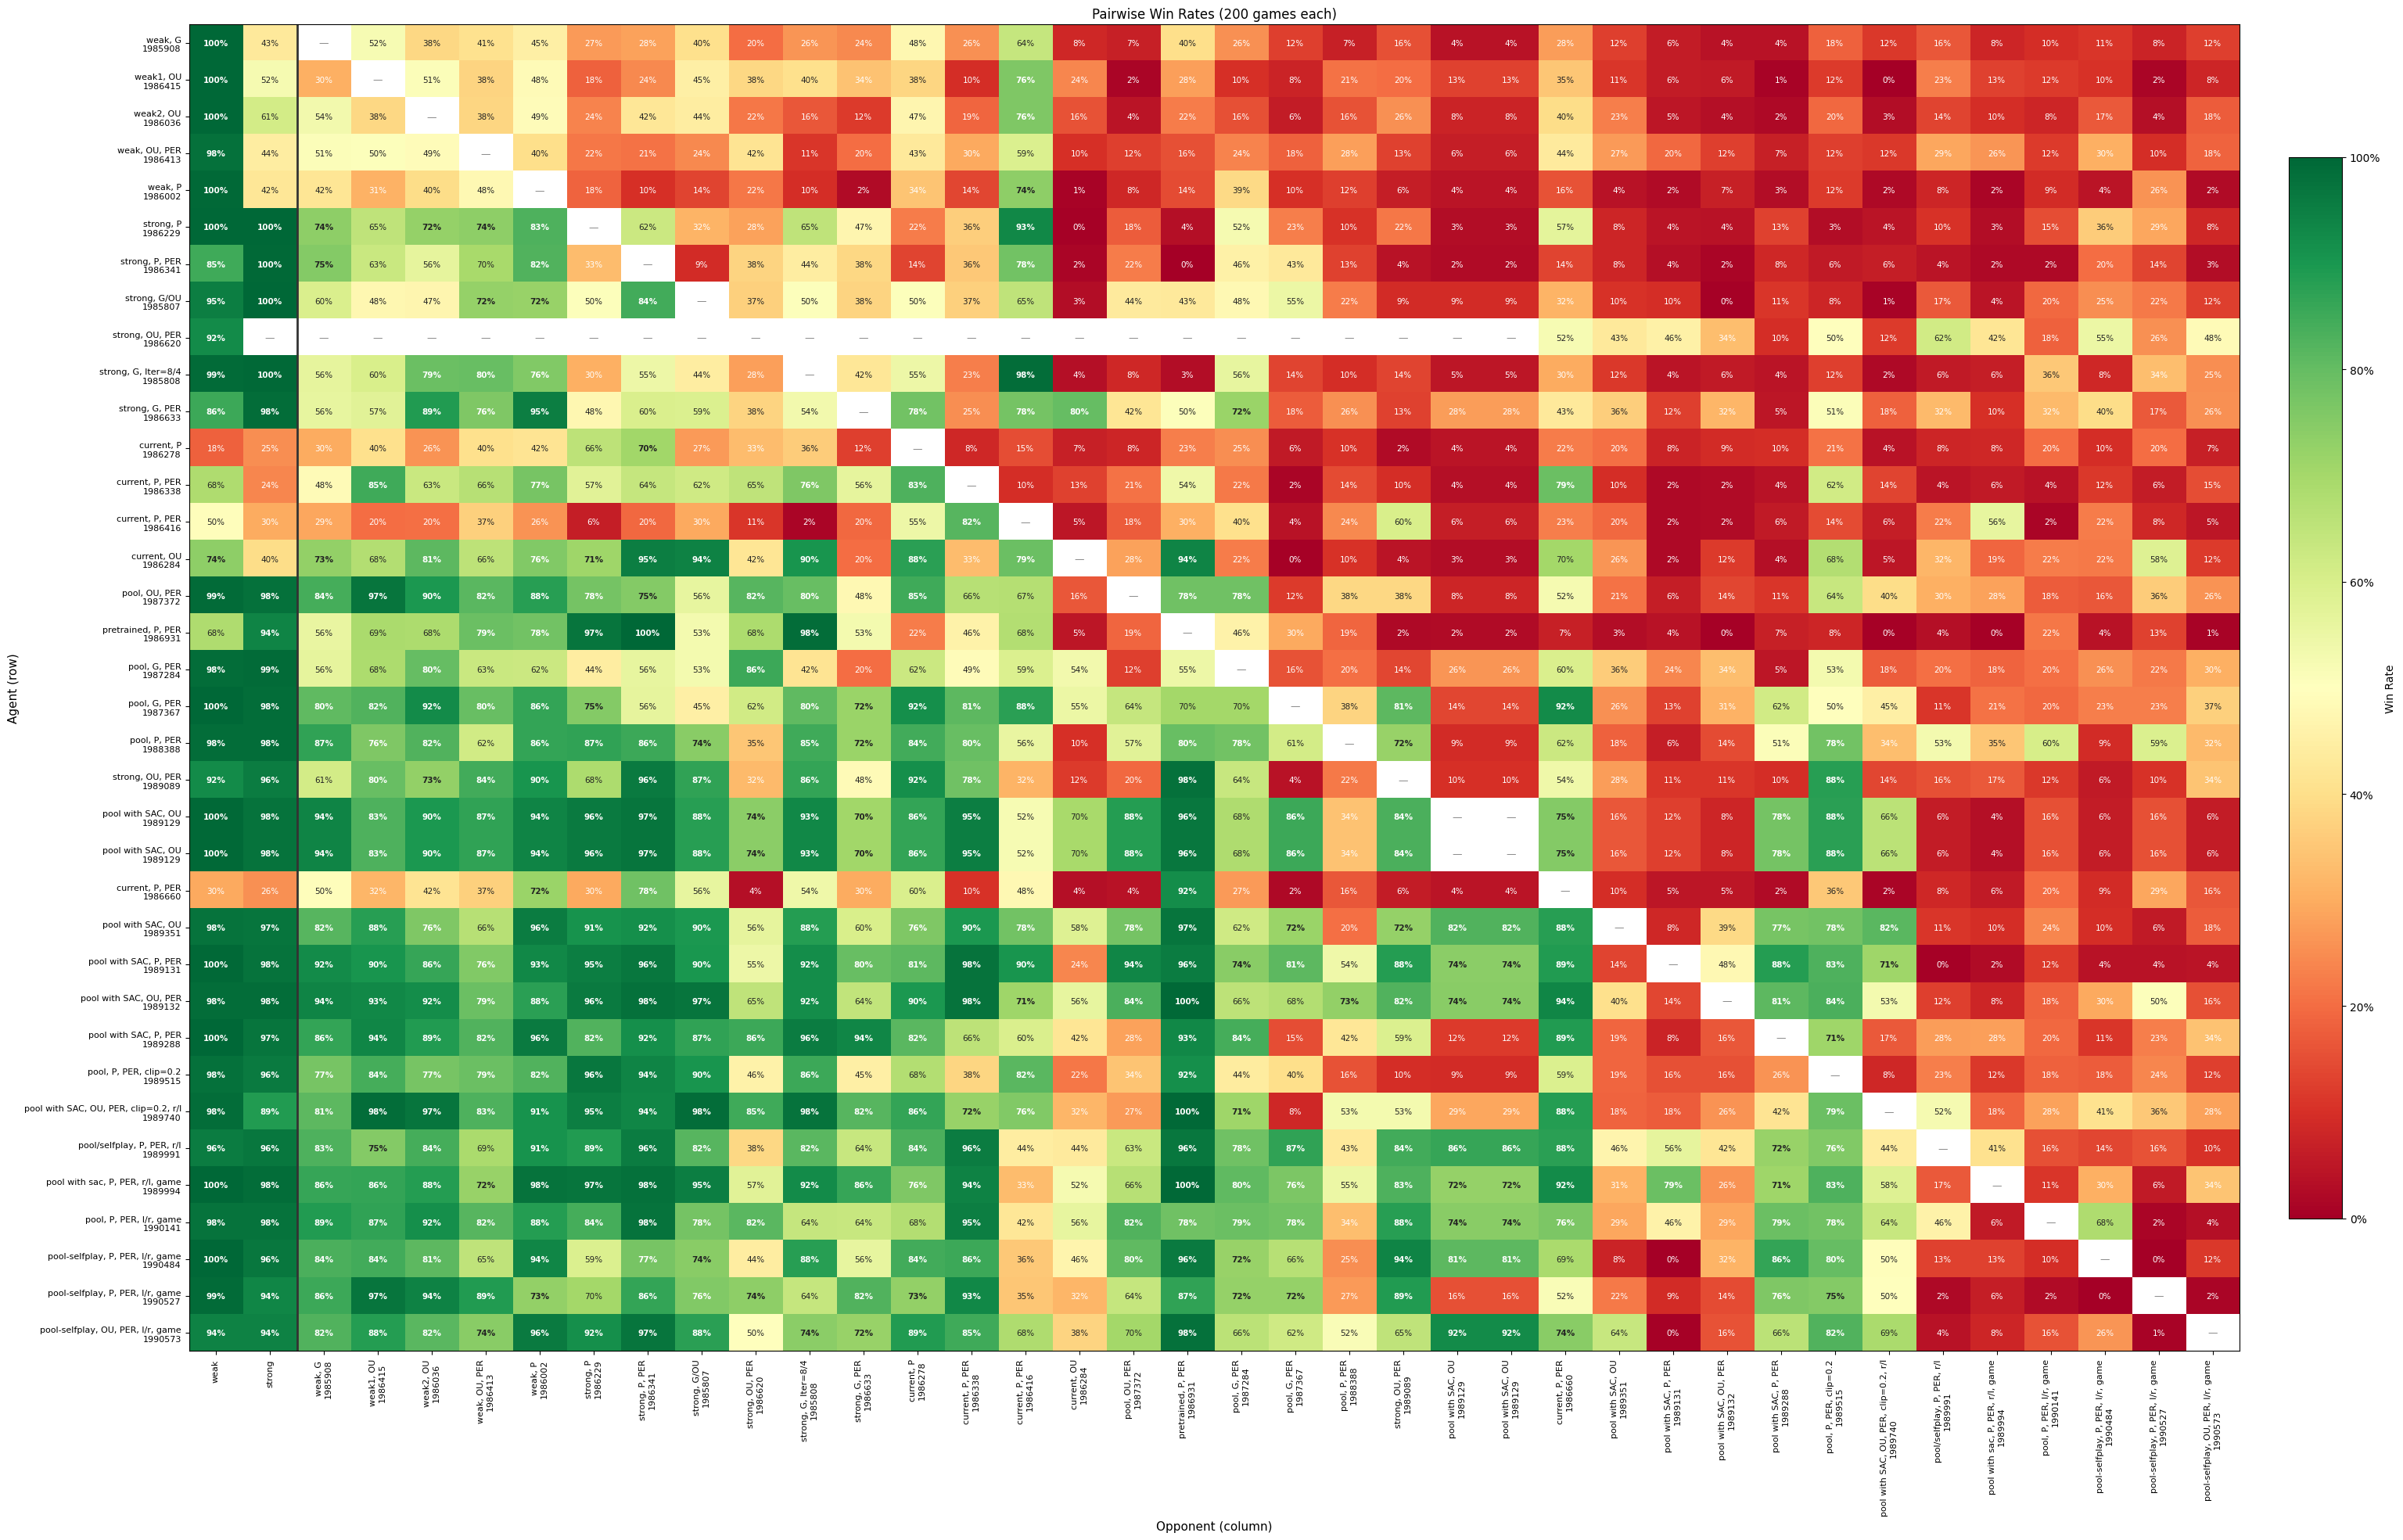

In [11]:
fig, ax = plt.subplots(figsize=(max(12, len(all_opponents) * 0.9),
                                max(6, len(agent_names) * 0.55)))

data = win_rate_matrix.values.astype(float)

im = ax.imshow(data, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')

# annotations
for i in range(len(agent_names)):
    for j in range(len(all_opponents)):
        val = data[i, j]
        if np.isnan(val):
            ax.text(j, i, '—', ha='center', va='center', fontsize=9, color='#888')
        else:
            r = results2[agent_names[i]].get(all_opponents[j])
            w, l, t = r
            color = 'white' if val < 0.35 or val > 0.75 else '#222'
            ax.text(j, i, f'{val:.0%}', #\n{w}W {l}L {t}T',
                    ha='center', va='center', fontsize=7.5, color=color,
                    fontweight='bold' if val > 0.7 else 'normal')

# axis labels
ax.set_xticks(range(len(all_opponents)))
ax.set_xticklabels(all_opponents, rotation=90, ha='center', fontsize=8)
ax.set_yticks(range(len(agent_names)))
ax.set_yticklabels(agent_names, fontsize=8, )
ax.set_xlabel('Opponent (column)', fontsize=11)
ax.set_ylabel('Agent (row)', fontsize=11)
ax.set_title(f'Pairwise Win Rates ({N_GAMES} games each)')

# colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.ax.set_ylabel('Win Rate', fontsize=10)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# divider line between basic opponents and agent matchups
ax.axvline(1.5, color='#333', linewidth=2, linestyle='-')

plt.tight_layout()
plt.savefig('pairwise_heatmap.png')
plt.show()

In [ ]:
# Compute overall stats per agent
ranking = []
for name in agent_names:
    total_w, total_l, total_t, n_matchups = 0, 0, 0, 0
    for opp in all_opponents:
        r = results2[name].get(opp)
        if r is not None:
            w, l, t = r
            total_w += w
            total_l += l
            total_t += t
            n_matchups += 1
    total_games = total_w + total_l + total_t
    ranking.append({
        'agent': name,
        'matchups': n_matchups,
        'wins': total_w,
        'losses': total_l,
        'ties': total_t,
        'win_rate': total_w / total_games if total_games > 0 else 0,
        'loss_rate': total_l / total_games if total_games > 0 else 0,
    })

ranking_df = pd.DataFrame(ranking).sort_values('win_rate', ascending=True)
ranking_df